In [1]:
#%%
import numpy as np
import netCDF4 as nc
import os
import re
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap,BoundaryNorm
import matplotlib.cm as cm
from matplotlib import colors
import imageio
import pygeodesy
from pygeodesy.ellipsoidalKarney import LatLon
import folium
from shapely.geometry import Point,Polygon
from folium.plugins import FastMarkerCluster

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
from cartopy.io import shapereader
from sklearn.metrics import mean_squared_error
import matplotlib.colors as mcolors

In [21]:
#%% change the settings
dahour = 6
dahour_str = '{:02d}'.format(dahour) 
day1 = 11
day2 = 13  #2019101400
stime = 283*24+9   #20191011
sda_time = 24*(day1-1)
soff_time = int(sda_time/dahour)
time_len = (day2-day1+1)*24
time_len_off = int((day2-day1+1)*24/dahour)
var_dis  = 'outflw' # check discharge
var_dep  = 'rivdph' # check water depth
ens_num  = 20

# var_name = var_dis
var_name = var_dep

if var_name == 'outflw':
    var_ylabel = 'Outflow (kg m-2 s-1)'
    var_dir = 'dis'
else:
    var_ylabel  = 'River Depth (m)'
    var_dir = 'wlv'

#exp  = 'exp_tej' # change runoff
exp  = 'exp_ils' # change rainfall
#exp  = 'exp_wid' # change wid 
#exp  = 'exp_hgt' # change hgt 
# exp  = 'exp_man' # change manning 

In [13]:
df  = pd.read_excel("/work/a06/yingying/MLIT/MLIT_FlowGauge_all_info.xlsx",sheet_name='All_locationsV2')
site_name = np.array(df.iloc[:,0])
ref = np.array(df.iloc[:,1])

#%% read the location of observations
file_alloc = 'gauge_good_wlv.txt'
# read allocate information
id_info = list()
ix      = list()
iy      = list()
with open('/work/a06/yingying/obs/alloc/'+file_alloc,'r') as file:
    alloc_info = file.readlines()
    for i in range(1,len(alloc_info)):
        id_info = id_info+[int(alloc_info[i].split()[0])]
        ix      = ix+[int(alloc_info[i].split()[8])-1]
        iy      = iy+[int(alloc_info[i].split()[9])-1]
id_info  = np.array(id_info)
ilon     = np.array(ix)
ilat     = np.array(iy)

def cal_situ_ref(id_info_new):
    ref_new = np.full(np.size(id_info_new),np.nan)
    for i in range(0,np.size(id_info_new)):
        where_ref = np.where(site_name==id_info_new[i])
        ref_new[i]= ref[where_ref]
    ref_new = np.where((ref_new>998.99)&(ref_new<999.5),np.nan,ref_new)
    return ref_new
site_ref = cal_situ_ref(id_info)


def read_nc(file,num):
    nf = nc.Dataset(file,'r')
    varname = nf.variables.keys()
    varname = list(varname)
    print(varname)
    lat = np.array(nf.variables[varname[1]][:])
    lon = np.array(nf.variables[varname[2]][:])
    var = np.array(nf.variables[varname[num]][:])
    var = np.where(var<-1000,np.nan,var)
    var = np.where(var>10**8,np.nan,var)
    return lat,lon,var

def read_ens_nc(file):
    nf = nc.Dataset(file,'r')
    varname = nf.variables.keys()
    varname = list(varname)
    print(varname)
    lat = np.array(nf.variables[varname[0]][:])
    lon = np.array(nf.variables[varname[1]][:])
    var = np.array(nf.variables[varname[3]][:])
    var = np.where(var<-100,np.nan,var)
    return lat,lon,var

#%% read data
map_path = '/work/a06/yingying/CaMa_v411/cmf_v411_pkg/map/tej_01min/'
def read_bin(map_path,filename):
    with open(map_path+filename, 'rb') as f:
        day_array = np.fromfile(f, dtype=np.float32)
        day_array = day_array.reshape(1320,1500)
        day_array = np.where(day_array<-999,np.nan,day_array)
    return day_array

def read_nextxy(filename):
    with open(map_path+filename, 'rb') as f:
        day_array = np.fromfile(f, dtype=np.int32)
        day_array = day_array.reshape(2,1320,1500)
        day_array = np.where(day_array<-999,np.nan,day_array)
    return day_array

/tmp/ipykernel_1204000/4088120698.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ref_new[i]= ref[where_ref]


In [14]:
#%% read ens range
def read_output(exp,dahour_str):
    typeA = "A" # online DA
    typeC = "C" # simulation
    typeF = "F" # offline DA
    output_path  = '/work/a06/yingying/Code/plot/'+exp+dahour_str+'/'
    # [time,lat,lon]
    if var_name == 'outflw':
        lat,lon,disC_max = read_ens_nc(output_path+var_dis+'/data'+typeC+'_max01_20.nc')
        lat,lon,disC_min = read_ens_nc(output_path+var_dis+'/data'+typeC+'_min01_20.nc')
        lat,lon,disC_mean = read_ens_nc(output_path+var_dis+'/data'+typeC+'_mean01_20.nc')
        lat,lon,disA_max = read_ens_nc(output_path+var_dis+'/data'+typeA+'_max01_20.nc')
        lat,lon,disA_min = read_ens_nc(output_path+var_dis+'/data'+typeA+'_min01_20.nc')
        lat,lon,disA_mean = read_ens_nc(output_path+var_dis+'/data'+typeA+'_mean01_20.nc')
        dataF = [-999]
    else:
        lat,lon,disC_max = read_ens_nc(output_path+var_dep+'/data'+typeC+'_max01_20.nc')
        lat,lon,disC_min = read_ens_nc(output_path+var_dep+'/data'+typeC+'_min01_20.nc')
        lat,lon,disC_mean = read_ens_nc(output_path+var_dep+'/data'+typeC+'_mean01_20.nc')
        lat,lon,disA_max = read_ens_nc(output_path+var_dep+'/data'+typeA+'_max01_20.nc')
        lat,lon,disA_min = read_ens_nc(output_path+var_dep+'/data'+typeA+'_min01_20.nc')
        lat,lon,disA_mean = read_ens_nc(output_path+var_dep+'/data'+typeA+'_mean01_20.nc')
        # read offline DA result
        lat,lon,dataF = read_nc(output_path+var_name+'/dataF.nc',3)
    
    simmean = np.nanmean(disC_mean,axis=0)
    return disC_max,disC_min,disC_mean,disA_max,disA_min,disA_mean,dataF,simmean
disC_max,disC_min,disC_mean,disA_max,disA_min,disA_mean,dataF,simmean = read_output('exp_ils','06')

['time', 'lat', 'lon', 'Outflw']
['time', 'lat', 'lon', 'Outflw']
['time', 'lat', 'lon', 'Outflw']
['time', 'lat', 'lon', 'Outflw']
['time', 'lat', 'lon', 'Outflw']
['time', 'lat', 'lon', 'Outflw']
['time', 'lat', 'lon', 'Outflw']


/tmp/ipykernel_1204000/2092830315.py:26: RuntimeWarning: Mean of empty slice
  simmean = np.nanmean(disC_mean,axis=0)


In [5]:
# fre_type = ['03','06','12']
# def read_exp_all(exp,):
#     ind = 0
#     disC_max_each = np.full((len(fre_type),np.shape(disC_max)[0],np.shape(disC_max)[1],np.shape(disC_max)[2]),np.nan)
#     disC_min_each = np.full((len(fre_type),np.shape(disC_max)[0],np.shape(disC_max)[1],np.shape(disC_max)[2]),np.nan)
#     disC_mean_each = np.full((len(fre_type),np.shape(disC_max)[0],np.shape(disC_max)[1],np.shape(disC_max)[2]),np.nan)
#     disA_max_each = np.full((len(fre_type),np.shape(disC_max)[0],np.shape(disC_max)[1],np.shape(disC_max)[2]),np.nan)
#     disA_min_each = np.full((len(fre_type),np.shape(disC_max)[0],np.shape(disC_max)[1],np.shape(disC_max)[2]),np.nan)
#     disA_mean_each = np.full((len(fre_type),np.shape(disC_max)[0],np.shape(disC_max)[1],np.shape(disC_max)[2]),np.nan)
#     dataF_each = np.full((len(fre_type),np.shape(dataF)[0],np.shape(dataF)[1],np.shape(dataF)[2]),np.nan)
#     simmean = np.full((len(fre_type),np.shape(disC_max)[1],np.shape(disC_max)[2]),np.nan)
#     for hour_str in fre_type:
#         disC_max_each[ind,:,:,:],disC_min_each[ind,:,:,:],disC_mean_each[ind,:,:,:],disA_max_each[ind,:,:,:],disA_min_each[ind,:,:,:],disA_mean_each[ind,:,:,:],dataF_each[ind,:,:,:],simmean_each[ind,:,:] = read_output(exp,hour_str)
#         ind = ind+1
#     return disC_max_all,disC_min_all,disC_mean_all,disA_max_all,disA_min_all,disA_mean_all,dataF_all,simmean_all
# disC_max_all,disC_min_all,disC_mean_all,disA_max_all,disA_min_all,disA_mean_all,dataF_all,simmean_all = read_exp_all(exp)
    

In [6]:
#%% read rainfall data
def read_prep(file):
    nf = nc.Dataset(file,'r')
    varname = nf.variables.keys()
    varname = list(varname)
    print(varname)
    lat = np.array(nf.variables[varname[1]][:])
    lon = np.array(nf.variables[varname[2]][:])
    var = np.array(nf.variables[varname[3]][:])
    var = var*3600 # unit: mm/h 
    var = np.array(np.where(var<-900,np.nan,var))
    return lat,lon,var
lat,lon,rainf = read_prep('/work/a06/yingying/ils_data/tej_rain.nc')

def write_bin(var_each,varname,num):
    var_flat = var_each.flatten()
    var_bin  = var_flat.astype('int32').tobytes()
    # write .bin
    fname    = "basin"+varname+str(num)
    filebin  = map_path+fname+'.bin'
    with open(filebin,'wb') as file:
        file.write(var_bin)
    
obs_path = '/work/a06/yingying/MLIT/data/data_'+var_dir+'_hour2019/'
def read_obs(situ_id):
    filename = str(situ_id)+'.bin'
    if os.path.exists(filename):            
        with open(obs_path+filename, 'rb') as f:
            day_array = np.fromfile(f, dtype=np.float64)
            day_array = np.where(day_array<-900,np.nan,day_array)
        f.close()
        return day_array
    else:
        return -999

['time', 'lat', 'lon', 'Precip']


In [7]:
# read map data
basin=read_bin(map_path,'basin.bin')
up_area = read_bin(map_path,'uparea.bin')
elvmean = read_bin(map_path,'elv_mean.bin')
elvmean = np.where(elvmean<-100,np.nan,elvmean)
nextlon = read_nextxy('nextxy.bin')[0,:,:]-1
nextlat = read_nextxy('nextxy.bin')[1,:,:]-1
nextlon = np.where(nextlon<0,np.nan,nextlon)
nextlat = np.where(nextlat<0,np.nan,nextlat)
# offpath = '/work/a06/yingying/camada/HydroDA/src/assim_'+exp[-3:]+dahour_str+'/ens_xa/meanA/201901'
# dataF = np.full((int((day2-day1+1)*24/dahour),1320,1500),np.nan)
# shour = 0
# for day in range(0,int((day2-day1+1)*24/dahour)):
#     date  = int(day//int(24/dahour))+1
#     fday = '{:02d}'.format(date)
#     fhour = '{:02d}'.format(shour)
#     dataF[day,:,:]=read_bin(offpath,fday+fhour+'_xa.bin')
#     shour = shour + dahour
#     if shour>23:
#         shour = shour-24

In [26]:
#%%  draw the da output
os.makedirs('/work/a06/yingying/plot/'+exp+dahour_str+'/',exist_ok=True)
os.makedirs('/work/a06/yingying/plot/'+exp+dahour_str+'/'+var_dir+'/',exist_ok=True)
os.makedirs('/work/a06/yingying/Code/plot/online/jupyter/'+exp+dahour_str+'/',exist_ok=True)

def draw_lines(loc,loc_lat,loc_lon,ylabel,loc_obs,loc_sim_mean,loc_sim_max,loc_sim_min,loc_da_mean,loc_da_max,loc_da_min,locF,rain):
    fig,ax1 = plt.subplots(dpi = 300,figsize=(6,3))
    fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.25)
    time    = np.arange(0,time_len,1)
    loc_lat = '{:04d}'.format(loc_lat)
    loc_lon = '{:04d}'.format(loc_lon)   
    # dis obs
    ax1.plot(time,loc_obs,color='blue',label='Obs',linewidth=1.5)
    # simulations
    ax1.plot(time,loc_sim_mean,'r-',linewidth=1.2,label='Sim')
    ax1.fill_between(time, loc_sim_max, loc_sim_min, color='red', alpha=0.2)
    ax1.fill_between(time, loc_da_max, loc_da_min, color='green', alpha=0.2)
    # offline DA
    for day in range(0,int((day2-day1+1)*24/dahour)-1):
        time_each = np.arange(day*dahour,(day+1)*dahour,1)
        if var_name == "rivdph":
            ax1.scatter(time_each[-1],locF[day], color='black', marker='*', s=30)
        sday = day*dahour
        eday = (day+1)*dahour
        ax1.plot(time_each,loc_da_mean[sday:eday],'g-',linewidth=1.2,alpha=0.7)       
        time_each_da =np.arange(sday,eday,1)
        ax1.scatter(time_each_da[0],loc_da_mean[sday],marker='.',color='green',alpha=0.9,s=30)
    # online DA
    day = day+1
    time_each = np.arange(day*dahour,(day+1)*dahour,1)
    ax1.plot(time_each,loc_da_mean[day*dahour:(day+1)*dahour],'g-',linewidth=1.2,alpha=0.7,label='Online DA')
    if var_name == 'rivdph':
        ax1.scatter(time_each[-1],locF[-1], color='black', marker='*', s=30,label='Offline DA')

    ax1.set_xlabel('Hour')
    ax1.set_ylabel(ylabel)
    ax1.set_xlim(0,time_len)
    ax1.set_title('DA with Anomaly Water Depth '+str(loc_lon)+str(loc_lat))    
    ax1.legend(loc='upper left')

    dates = pd.date_range(start='2019-10-11 09:00',end='2019-10-14 08:00',freq='h')
    ax1.set_xticks(np.arange(15,time_len,24))
    ax1.set_xticklabels(dates[15::24],rotation=15)

    ax2 = ax1.twinx()
    ax2.invert_yaxis()
    ax2.bar(time,rain,color='gray',alpha=0.8)
    ax2.set_ylabel('Prep (mm/h)')
    ax2.set_ylim(np.nanmax(rain)+25,0)
    ax2.spines['right'].set_color('gray')
    ax2.yaxis.label.set_color('gray')
    ax2.tick_params(axis='y',colors='gray')
    plt.show()
    # plt.savefig('/work/a06/yingying/Code/plot/online/jupyter/'+exp+dahour_str+'/'+var_dir+'_'+str(loc)+'.jpg', format='jpg',dpi=300)
    plt.close()

def draw_obs(loc1,loc2,disC_mean,disC_max,disC_min,disA_mean,disA_max,disA_min,dataF,simmean):
    for loc in range(loc1,loc2):
        loc_lat = ilat[loc]
        loc_lon = ilon[loc]
        loc_ref = site_ref[loc]
        loc_id  = id_info[loc]
        #obs
        obs_path = '/work/a06/yingying/MLIT/data/data_'+var_dir+'_hour2019/'
        filename = obs_path+str(loc_id)+'.bin'
        print(filename)
        if os.path.exists(filename):            
            with open(filename, 'rb') as f:
                obs = np.fromfile(f, dtype=np.float64)
                obs = np.where(obs<-900,np.nan,obs)
                obs = np.where(obs>10**7,np.nan,obs)
            # simulation
            if var_name == 'outflw':
                # Japanese time is 9 hours later than UTC
                disC_sim_mean = disC_mean[sda_time:sda_time+time_len,loc_lat,loc_lon]
                disC_sim_max = disC_max[sda_time:sda_time+time_len,loc_lat,loc_lon]
                disC_sim_min = disC_min[sda_time:sda_time+time_len,loc_lat,loc_lon]
                disA_da_mean = disA_mean[sda_time:sda_time+time_len,loc_lat,loc_lon]
                print(np.nanmax(disA_da_mean))
                disA_da_max  = disA_max[sda_time:sda_time+time_len,loc_lat,loc_lon]
                disA_da_min  = disA_min[sda_time:sda_time+time_len,loc_lat,loc_lon]
                dis_obs = obs[stime:stime+time_len]
                disF_loc= np.full((int((day2-day1+1)*24/dahour),1320,1500),np.nan)
            else:
                disC_sim_mean = disC_mean[sda_time:sda_time+time_len,loc_lat,loc_lon]-simmean[loc_lat,loc_lon]
                disC_sim_max = disC_max[sda_time:sda_time+time_len,loc_lat,loc_lon]-simmean[loc_lat,loc_lon]
                disC_sim_min = disC_min[sda_time:sda_time+time_len,loc_lat,loc_lon]-simmean[loc_lat,loc_lon]
                disA_da_mean = disA_mean[sda_time:sda_time+time_len,loc_lat,loc_lon]-simmean[loc_lat,loc_lon]
                disA_da_max  = disA_max[sda_time:sda_time+time_len,loc_lat,loc_lon]-simmean[loc_lat,loc_lon]
                disA_da_min  = disA_min[sda_time:sda_time+time_len,loc_lat,loc_lon]-simmean[loc_lat,loc_lon]
                dis_obs = obs[stime:stime+time_len]-elvmean[loc_lat,loc_lon]
                #offline DA
                disF_loc= dataF[soff_time:soff_time+time_len_off,loc_lat,loc_lon]
            if np.all(disA_mean[50:100,loc_lat,loc_lon]<10**(-8))==True:
                disA_da_mean = np.full(time_len,np.nan)
            rain    = rainf[sda_time:sda_time+time_len,loc_lat,loc_lon]
            draw_lines(loc,loc_lat,loc_lon,var_ylabel,dis_obs,disC_sim_mean,disC_sim_max,disC_sim_min,disA_da_mean,disA_da_max,disA_da_min,disF_loc,rain)
        else:
            print(var_name+': no observation')

/work/a06/yingying/MLIT/data/data_wlv_hour2019/303051283310070.bin
36


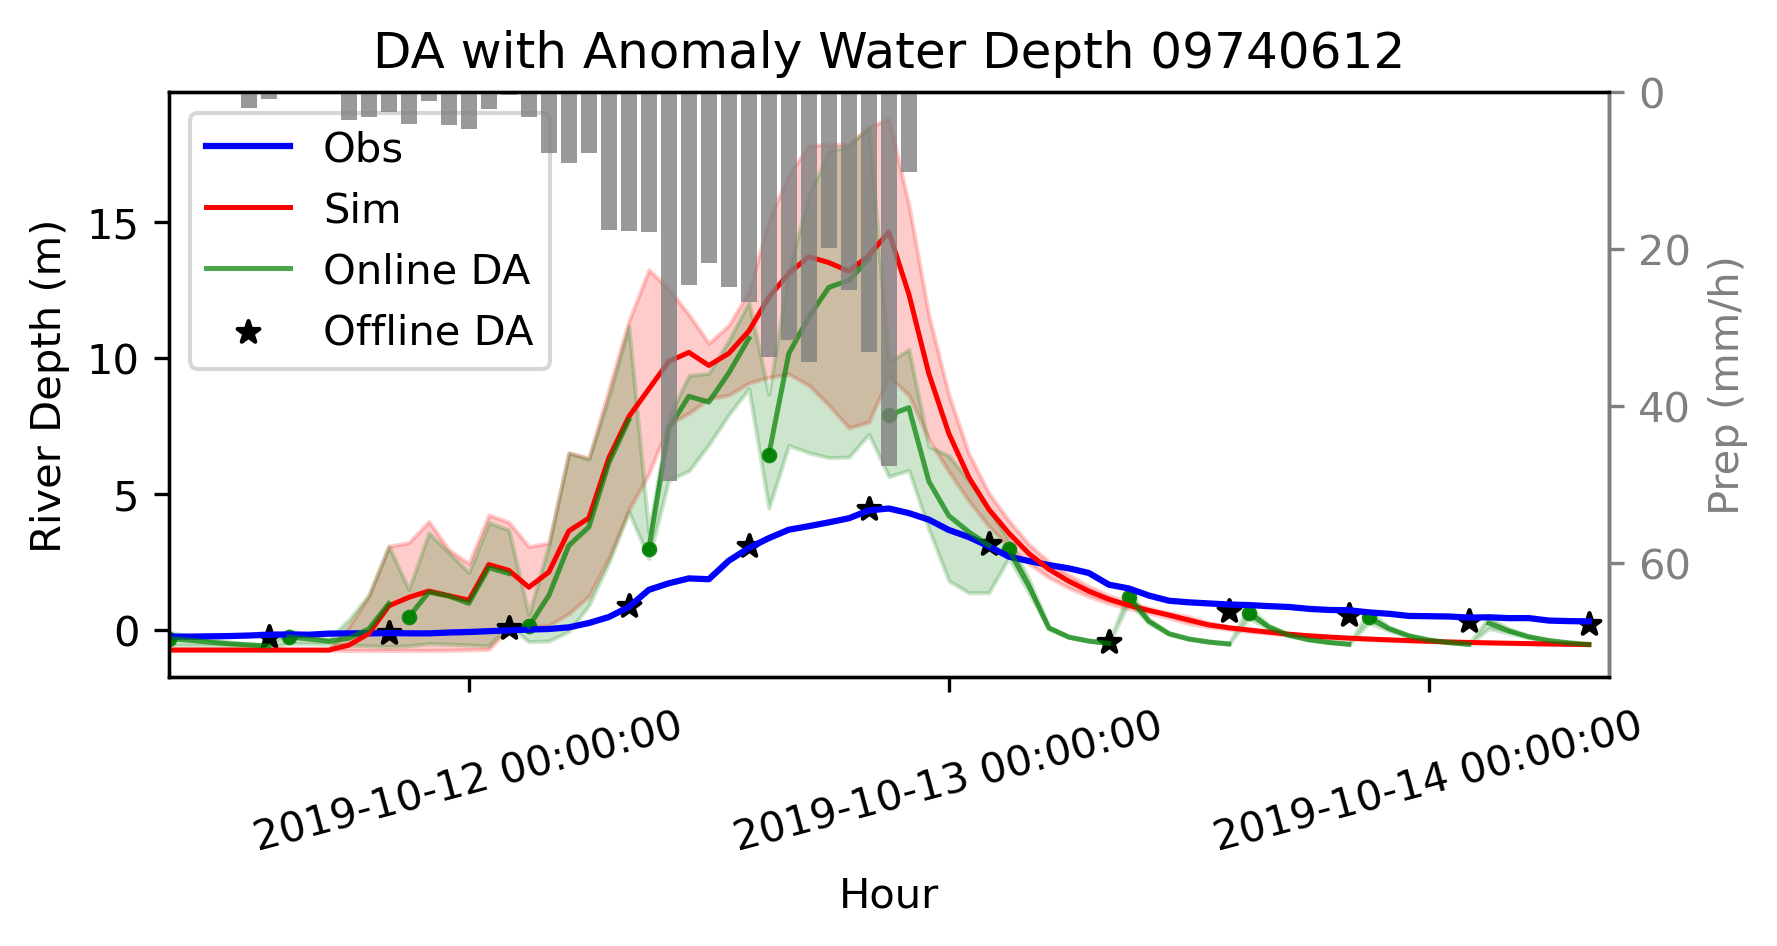

/work/a06/yingying/MLIT/data/data_wlv_hour2019/303051283310060.bin
37


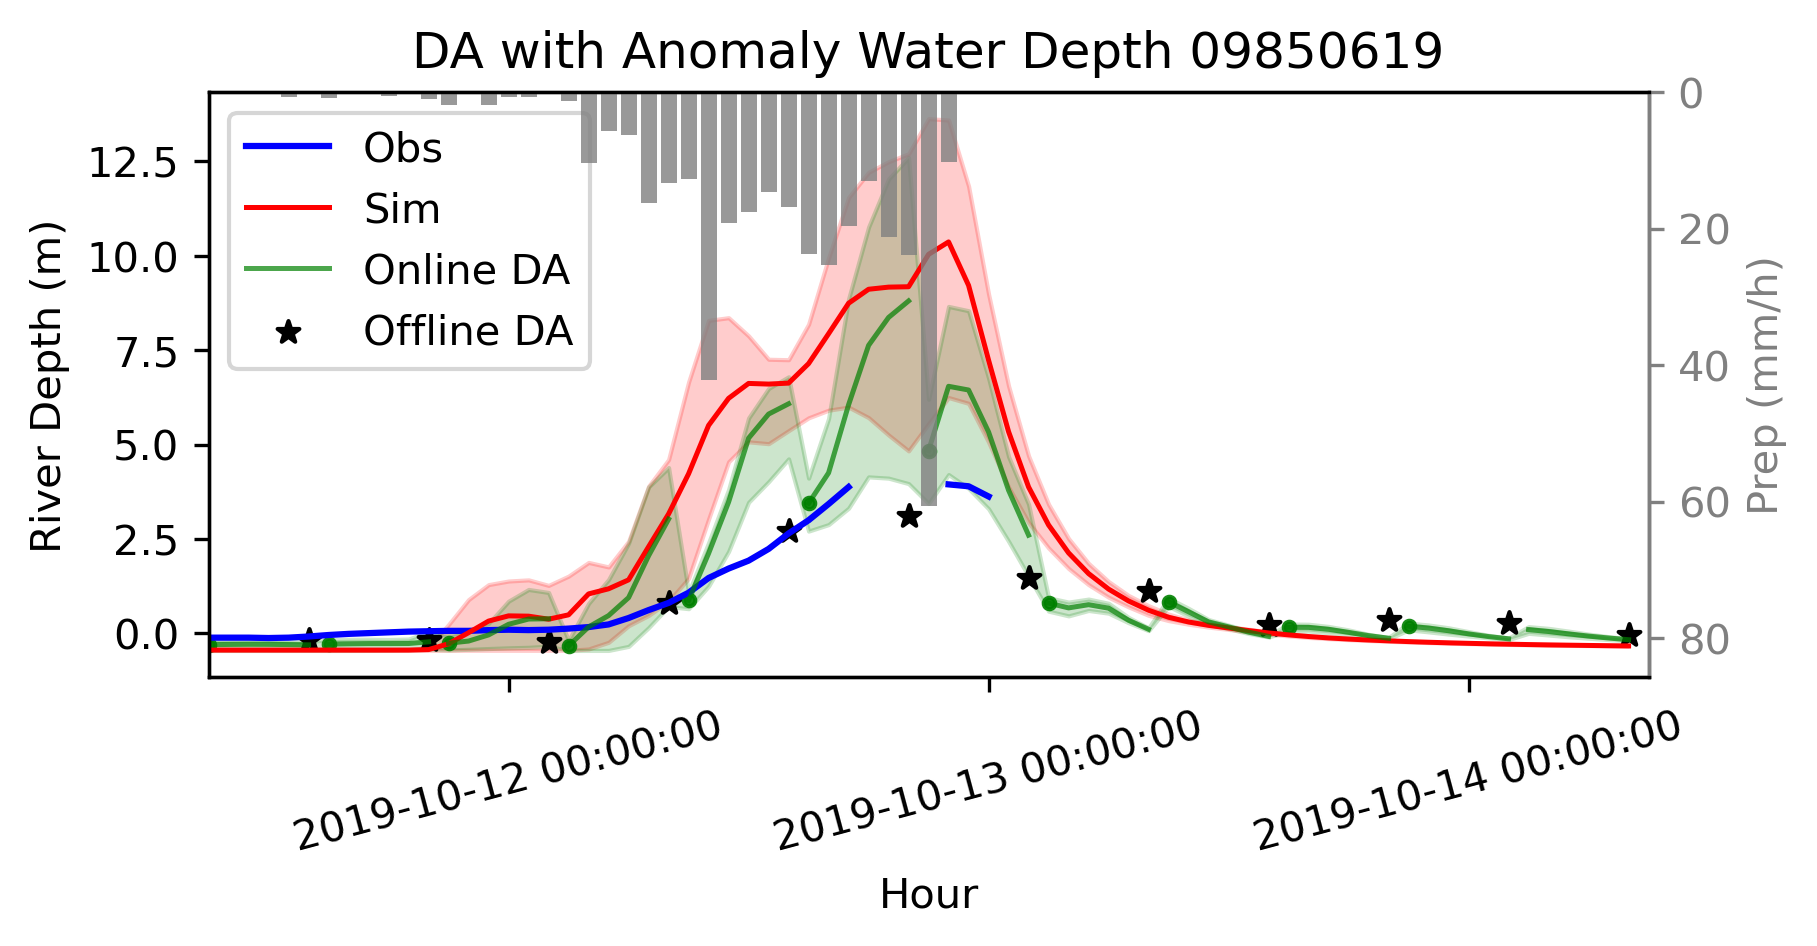

/work/a06/yingying/MLIT/data/data_wlv_hour2019/303051283310050.bin
37


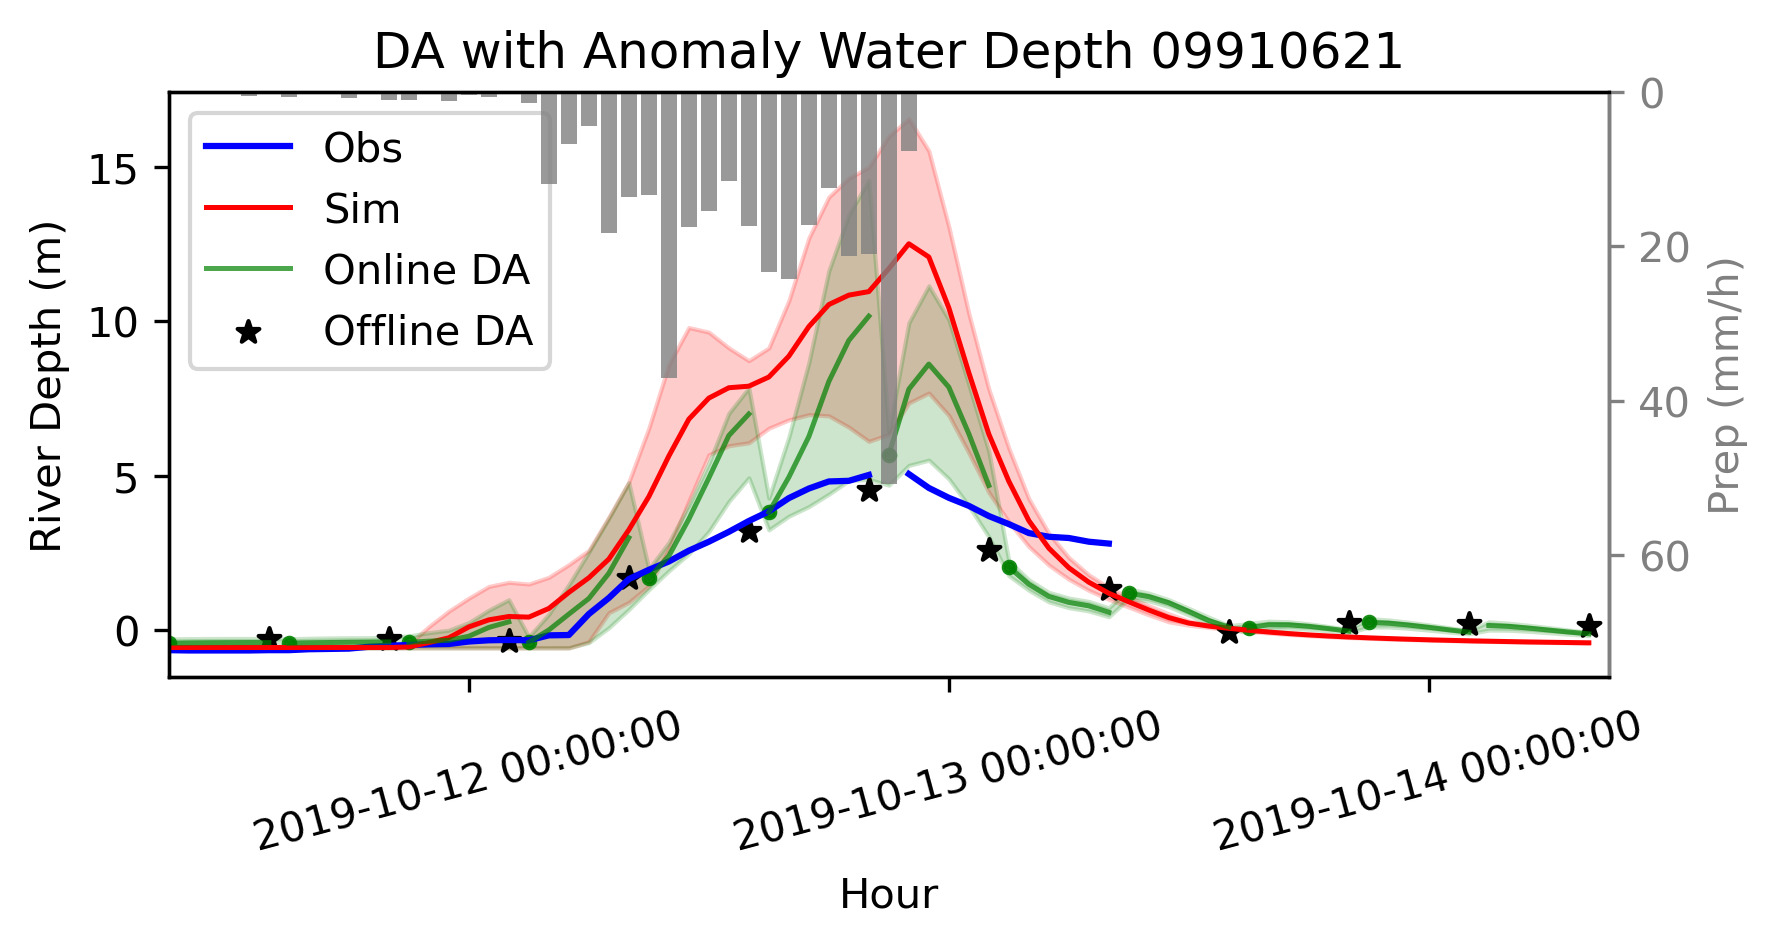

/work/a06/yingying/MLIT/data/data_wlv_hour2019/304031284416100.bin
42


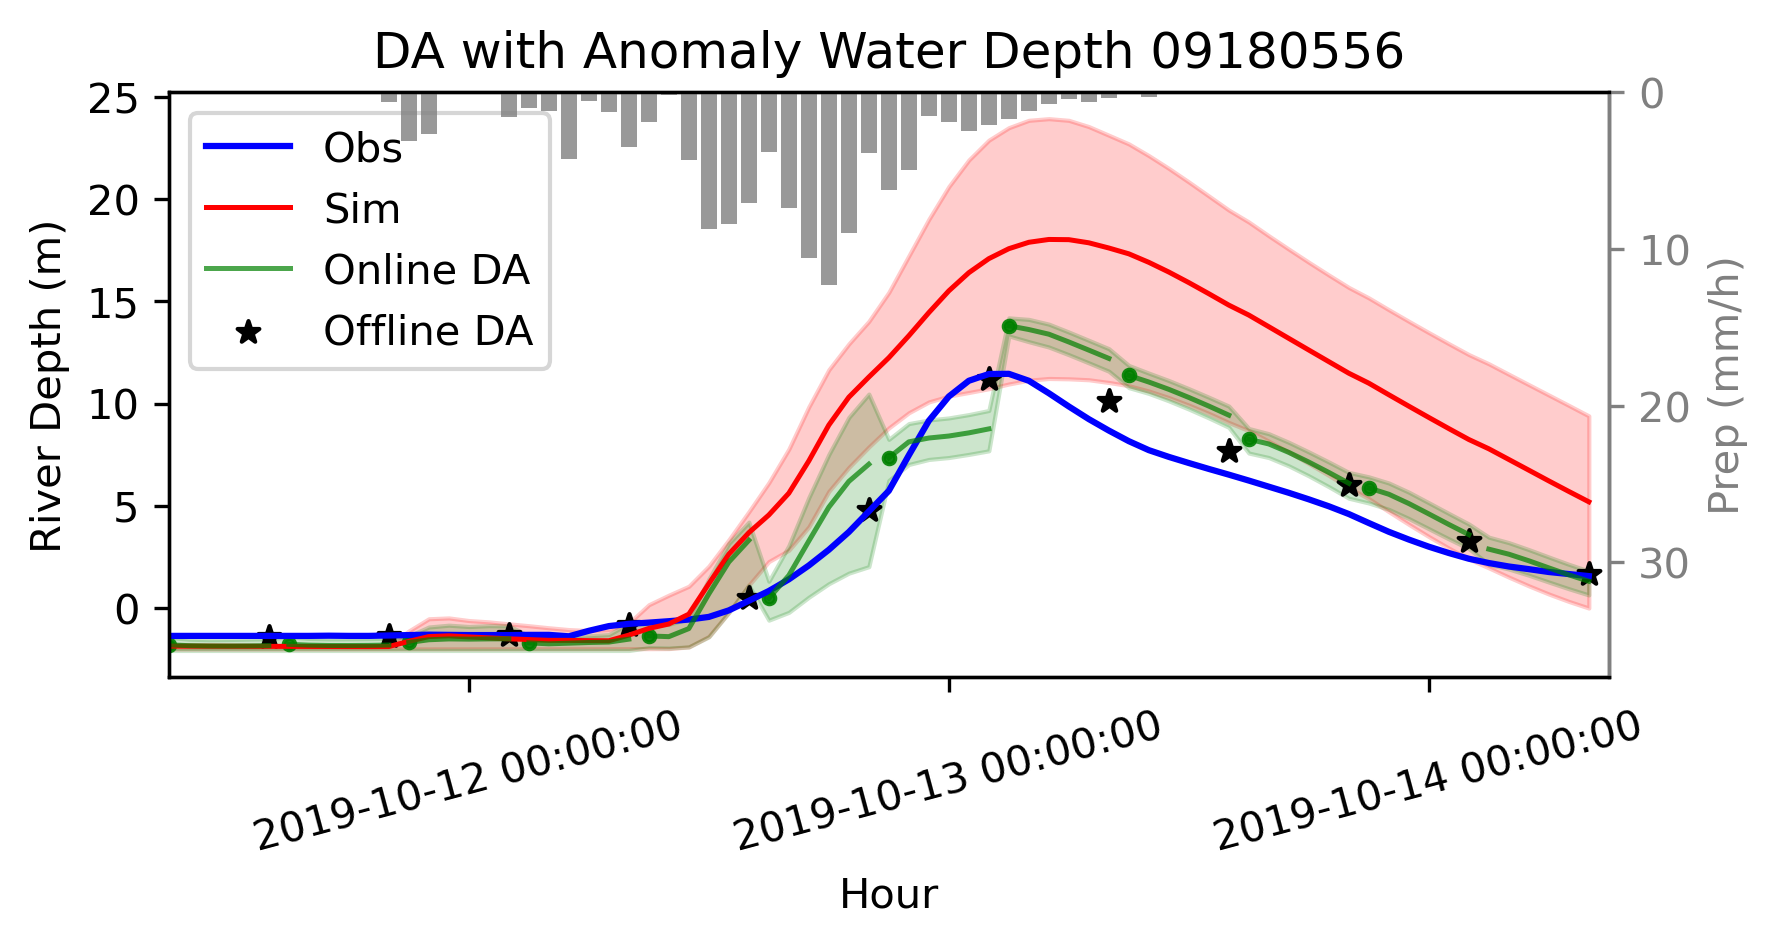

In [27]:
draw_obs(704,705,disC_mean,disC_max,disC_min,disA_mean,disA_max,disA_min,dataF,simmean) #upstream
draw_obs(703,704,disC_mean,disC_max,disC_min,disA_mean,disA_max,disA_min,dataF,simmean) #downstream
draw_obs(702,703,disC_mean,disC_max,disC_min,disA_mean,disA_max,disA_min,dataF,simmean) #downstream
# from flooded area
draw_obs(787,788,disC_mean,disC_max,disC_min,disA_mean,disA_max,disA_min,dataF,simmean) #downstream

In [24]:
#%% NRMSE
def draw_each_figure(obs_lat,obs_lon,disC_mean,disA_mean):
    situ_rmse  = np.full(np.shape(obs_lat)[0],np.nan)
    situ_nrmse  = np.full(np.shape(obs_lat)[0],np.nan)
    lat_plot   = np.full(np.shape(obs_lat)[0],np.nan)
    lon_plot   = np.full(np.shape(obs_lat)[0],np.nan)
    situ_imp   = np.full(np.shape(obs_lat)[0],np.nan)
    peak_time_obs = np.full(np.shape(obs_lat)[0],np.nan)
    loc_row = np.full(np.shape(obs_lat)[0],np.nan)
    
    for loc in range(0,np.shape(obs_lat)[0]):
        loc_lat = obs_lat[loc]
        loc_lon = obs_lon[loc]
        loc_id  = id_info[loc]
        #obs
        obs_path = '/work/a06/yingying/MLIT/data/data_'+var_dir+'_hour2019/'
        filename = obs_path+str(loc_id)+'.bin'
        if os.path.exists(filename):            
            with open(filename, 'rb') as f:
                obs = np.fromfile(f, dtype=np.float64)
                obs = np.where(obs<-900,np.nan,obs)
                obs = np.where(obs>10**4,np.nan,obs)   

        # read data
            if var_name == 'outflw':
                loc_sim = disC_mean[sda_time:sda_time+time_len,loc_lat,loc_lon]
                loc_obs = obs[stime:stime+time_len]
                loc_da  = disA_mean[sda_time:sda_time+time_len,loc_lat,loc_lon]
            else:
                loc_sim = disC_mean[sda_time:sda_time+time_len,loc_lat,loc_lon]-simmean[loc_lat,loc_lon]
                loc_obs = obs[stime:stime+time_len]-elvmean[loc_lat,loc_lon]
                loc_da  = disA_mean[sda_time:sda_time+time_len,loc_lat,loc_lon]-simmean[loc_lat,loc_lon]
            if np.all(disA_mean[10:30,loc_lat,loc_lon]<10**(-8))==True:
                loc_da = np.full(time_len,np.nan)
            # remove no obs stations   
            mse_sim = np.nanmean((loc_obs-loc_sim)**2)
            mse_da  = np.nanmean((loc_obs-loc_da)**2)
            if np.isnan(mse_sim) | np.isnan(mse_da) | np.all(loc_da[10:30]<0):
                continue
            rmse = np.sqrt(mse_sim) - np.sqrt(mse_da)
            if (np.shape(loc_obs)[0]<5) | (np.shape(loc_sim)[0]<5) | (np.shape(loc_da)[0]<5):
                rmse = np.nan
                nrmse = np.nan
                imp = np.nan
            else:
                var_max  = np.nanmax(loc_obs)
                var_min  = np.nanmin(loc_obs)
                var_range = var_max-var_min
                nrmse    = rmse/var_range
                peak_time_obs_each = np.nanargmax(loc_obs)
                # if nrmse<-0.2:
                #     print(nrmse,rmse,loc_lat,loc_lon)
                imp = rmse/np.sqrt(mse_sim)            
            # store nrmse, lat, loc
            situ_rmse[loc]=rmse
            situ_nrmse[loc]=nrmse
            situ_imp[loc]=imp
            lat_plot[loc]=loc_lat
            lon_plot[loc]=loc_lon
            loc_row[loc]=loc
            peak_time_obs[loc]=peak_time_obs_each
        else:
            continue
    return situ_rmse,situ_nrmse,lat_plot,lon_plot,situ_imp,peak_time_obs,loc_row
situ_rmse,situ_nrmse,lat_plot,lon_plot,situ_imp,peak_time_obs,loc_row = draw_each_figure(ilat,ilon,disC_mean,disA_mean)
# print(situ_nrmse)

def performance(situ_nrmse,situ_imp):
    nrmse_pos = np.shape(np.where(situ_nrmse>0))[1]/(np.shape(np.where(situ_nrmse>0))[1]+np.shape(np.where(situ_nrmse<0))[1])
    nrmse_neg = 1-nrmse_pos
    print('better',nrmse_pos,'worse',nrmse_neg)
    print('average performance',np.nanmean(situ_nrmse),np.nanmean(situ_imp))
performance(situ_nrmse,situ_imp)

/tmp/ipykernel_534227/1532836026.py:37: RuntimeWarning: Mean of empty slice
  mse_da  = np.nanmean((loc_obs-loc_da)**2)
/tmp/ipykernel_534227/1532836026.py:36: RuntimeWarning: Mean of empty slice
  mse_sim = np.nanmean((loc_obs-loc_sim)**2)
/tmp/ipykernel_534227/1532836026.py:49: RuntimeWarning: divide by zero encountered in scalar divide
  nrmse    = rmse/var_range


better 0.8537794299876085 worse 0.14622057001239153
average performance nan -0.049734463218278555


/tmp/ipykernel_534227/1532836026.py:49: RuntimeWarning: invalid value encountered in scalar divide
  nrmse    = rmse/var_range
/home/yingying/miniconda/envs/data/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [25]:
#%% draw the map
def draw_rmse(title,lon_plot,lat_plot,situ_rmse,vmin,vmax):
    fig = plt.figure(dpi = 600,figsize=(7.5,4.5))
    ax1 = fig.add_axes([0.1,0.1,0.8,0.8],projection=ccrs.PlateCarree())
    ax1.set_axis_off()
    # ax1.outline_patch.set_linewidth(0.35)
    ax1.set_extent([128,149,30,46], ccrs.PlateCarree())
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=0, linestyle='-.')
    ax1.coastlines(alpha=1.,linestyle='-',color = "#3F3A3A",lw=0.8,resolution='10m')
    
    # mask the other place
    region_lon1 = [128.06, 128.06,138, 138 ]
    region_lat1 = [41 , 45.95 , 45.95, 41  ]
    region_lon2 = [128.06,128.06,131.4,131.4 ]
    region_lat2 = [34.5,41,41,34.5]
    ax1.fill(region_lon1, region_lat1, color='white', transform=ccrs.PlateCarree(), zorder=10)
    ax1.fill(region_lon2, region_lat2, color='white', transform=ccrs.PlateCarree(), zorder=10)
    
    gl.top_labels   = False
    gl.right_labels = False
    gl.bottom_labels   = False
    gl.left_labels = False
    # gl.xlocator = mticker.FixedLocator([130,135,140,145])
    # gl.ylocator = mticker.FixedLocator([30,35,40,45])
    # gl.xlabel_style = {'size': 8,'color':"#3F3A3A",'weight':'normal'}
    # gl.ylabel_style = {'size': 8,'color':"#3F3A3A",'weight':'normal'}
    # lon_formatter = LongitudeFormatter(zero_direction_label=True)
    # lat_formatter = LatitudeFormatter()
    # ax1.xaxis.set_major_formatter(lon_formatter)
    # ax1.yaxis.set_major_formatter(lat_formatter)
    norm = mcolors.TwoSlopeNorm(vmin=min(situ_rmse), vcenter=0, vmax=-min(situ_rmse))
    con_plot2 = ax1.scatter(lon[ilon],lat[ilat],c=situ_rmse,s=1.5,zorder=2,cmap='coolwarm',transform=ccrs.PlateCarree(),vmin=vmin,vmax=vmax,alpha=0.8)
    def color_bar(l,b,w,h):
      rect = [l,b,w,h]
      cbar_ax = fig.add_axes(rect)
      return cbar_ax
    [l1,b1,w1,h1] = [0.63,0.12,0.01,0.25]
    [l2,b2,w2,h2] = [0.63,0.32,0.01,0.25]
    cbar_ax2 = color_bar(l2,b2,w2,h2)

    # cb1.ax.set_title('NRMSE \n $(m^{3}/s)$',fontdict=font_label)
    cb2 = plt.colorbar(con_plot2, cax=cbar_ax2,orientation="vertical",shrink=0.5)
    ax1.set_title(title,loc='center')
    # plt.show()
    plt.savefig('/work/a06/yingying/Code/plot/online/jupyter/'+exp+dahour_str+'/'+var_dir+'_'+title+'.jpg', format='jpg',dpi=600)
    plt.close()
if var_name == 'rivdph':
    draw_rmse(var_name+'_RMSE',lon_plot,lat_plot,situ_rmse,-1,1)   
else:
    draw_rmse(var_name+'_RMSE',lon_plot,lat_plot,situ_rmse,-np.nanmax(situ_rmse)*0.6,np.nanmax(situ_rmse)*0.6)   
draw_rmse(var_name+'_nRMSE',lon_plot,lat_plot,situ_nrmse,-0.4,0.4)   
draw_rmse(var_name+'_Improvement',lon_plot,lat_plot,situ_imp,0,1)   
np.save('/work/a06/yingying/Code/plot/online/jupyter/'+exp+dahour_str+'/'+var_dir+'_'+'rmse.npy',situ_rmse)
np.save('/work/a06/yingying/Code/plot/online/jupyter/'+exp+dahour_str+'/'+var_dir+'_'+'nrmse.npy',situ_nrmse)
np.save('/work/a06/yingying/Code/plot/online/jupyter/'+exp+dahour_str+'/'+var_dir+'_'+'imp.npy',situ_imp)


In [26]:
#%% interactive map
def plot_interactive(loc_row,disC_mean,disA_mean,situ_rmse,peak_time_obs):
    situ_loc = np.zeros((np.shape(lon_plot)[0],2))
    # lat,lon
    situ_loc[:,0] = lat[ilat]
    situ_loc[:,1] = lon[ilon]
    lat_cen = 40
    lon_cen = 141
    my_map = folium.Map(location=(lat_cen,lon_cen),width=1000,height=600, zoom_start=10,attr="Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.")
    
    cmap = plt.cm.coolwarm
    num_points = np.shape(lon_plot)[0]
    norm = plt.Normalize(-1,1,num_points-1)              
    
    # Save the map to an HTML file
    ind = 0
    for coord in situ_loc:
        # read related data
        loc_lat = ilat[ind]
        loc_lon = ilon[ind]
        loc_id  = id_info[ind]
        #obs
        obs_path = '/work/a06/yingying/MLIT/data/data_'+var_dir+'_hour2019/'
        filename = obs_path+str(loc_id)+'.bin'
        if os.path.exists(filename):   
            with open(filename, 'rb') as f:
                obs = np.fromfile(f, dtype=np.float64)
                obs = np.where(obs<-900,np.nan,obs)
                obs = np.where(obs>10**6,np.nan,obs)
            f.close()
    
        # read data
            if var_name == 'outflw':
                loc_sim = disC_mean[0:time_len,loc_lat,loc_lon]
                loc_obs = obs[stime:stime+time_len]
                loc_da  = disA_mean[0:time_len,loc_lat,loc_lon]
            else:
                loc_sim = disC_mean[0:time_len,loc_lat,loc_lon]-simmean[loc_lat,loc_lon]
                loc_obs = obs[stime:stime+time_len]-elvmean[loc_lat,loc_lon]
                loc_da  = disA_mean[0:time_len,loc_lat,loc_lon]-simmean[loc_lat,loc_lon]
            if np.isnan(peak_time_obs[ind]):
                loc_obs_str = 'None'
                loc_sim_str = 'None'
                loc_da_str = 'None'
            else:
                loc_obs_str = '{:.2f}'.format(loc_obs[int(peak_time_obs[ind])])
                loc_sim_str = '{:.2f}'.format(loc_sim[int(peak_time_obs[ind])])
                loc_da_str  = '{:.2f}'.format(loc_da[int(peak_time_obs[ind])])
            rmse_str = '{:.2f}'.format(situ_rmse[ind])
            color = colors.to_hex(cmap(norm(situ_rmse[ind])))
            if var_name == 'rivdph':
                pop = f"id:{loc_id}<br>loc_row: {loc_row[ind]}<br>delta_rmse: {rmse_str}<br>wlv_obs: {loc_obs_str}<br>wlv_sim: {loc_sim_str}<br>wlv_da: {loc_da_str}"
            else:
                pop = f"id:{loc_id}<br>loc_row: {loc_row[ind]}<br>delta_rmse: {rmse_str}<br>dis_obs: {loc_obs_str}<br>dis_sim: {loc_sim_str}<br>dis_da: {loc_da_str}"
            folium.CircleMarker(
                location=coord,
                popup=pop,
                radius=5,
                color=color,  # Assign color based on index
                fill=True,
                fill_color=color,
                fill_opacity=0.6,
            ).add_to(my_map)
        ind = ind+1
    my_map.save(exp+'_'+var_name+'_map.html')
    return my_map

my_map = plot_interactive(loc_row,disC_mean,disA_mean,situ_rmse,peak_time_obs)
my_map

In [50]:
simmean = np.nanmean(disC_mean,axis=0)

/tmp/ipykernel_440077/2889650537.py:1: RuntimeWarning: Mean of empty slice
  simmean = np.nanmean(disC_mean,axis=0)
